# Import Libraries

In [1]:
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import defaultdict
from dataset import dataset_addb
from models import vqvae
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load Data

In [2]:
# Create the data loader (adjust window_size, batch_size as needed)
loader = dataset_addb.addb_data_loader(data_dir='/home/mnt/Datasets/AddBiomechanics', mode='train')


100%|██████████| 56/56 [03:42<00:00,  3.97s/it]

Total number of motions: 848


# Load VQ-VAE Model

In [3]:
# Set up args with the same parameters as in run.log
class Args:
    dataname = "mcs"
    nb_code = 512
    code_dim = 512
    output_emb_width = 512
    down_t = 2
    stride_t = 2
    width = 512
    depth = 3
    dilation_growth_rate = 3
    vq_act = "relu"
    vq_norm = None
    quantizer = "ema_reset"
    mu = 0.99


args = Args()

# Instantiate the model
model = vqvae.HumanVQVAE(
    args,
    nb_code=args.nb_code,
    code_dim=args.code_dim,
    output_emb_width=args.output_emb_width,
    down_t=args.down_t,
    stride_t=args.stride_t,
    width=args.width,
    depth=args.depth,
    dilation_growth_rate=args.dilation_growth_rate,
    activation=args.vq_act,
    norm=args.vq_norm
)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ckpt = torch.load("/home/mnt/BIGE/output/VQVAE9/300000.pth", map_location=device)

# Remove 'module.' prefix if present
state_dict = ckpt['net']
new_state_dict = {}
for k, v in state_dict.items():
    new_key = k.replace('module.', '') if k.startswith('module.') else k
    new_state_dict[new_key] = v

model.load_state_dict(new_state_dict, strict=True)
model.eval()

# Access the encoder
encoder = model.vqvae.encoder

# Create Latent Embeddings

In [4]:
def extract_subject_from_name(name):
    b3d_path = name.split("::")[0]
    parts = b3d_path.split(os.sep)
    if len(parts) >= 2:
        folder = parts[-2]
        # If '_split' in folder, take everything before '_split'
        if '_split' in folder:
            return folder.split('_split')[0]
        else:
            return folder
    else:
        return "unknown_subject"

subject_latents = defaultdict(list)

with torch.no_grad():
    for batch in loader:
        motions, lengths, names, subject_names, _ = batch  # Unpack the biomech field but ignore it
        motions = motions.to(device, dtype=torch.float32)
        latents = model.vqvae.encoder(model.vqvae.preprocess(motions))
        for latent, name, subject_name in zip(latents, names, subject_names):
            subject_latents[subject_name].append(latent.cpu())

# Profile Encoder

## Model

In [5]:
class ProfileEncoder(nn.Module):
    def __init__(self, latent_dim, profile_dim, meta_dim, biomech_dim, time_dim):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=latent_dim, num_heads=4, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        # Project meta, biomech, and time to latent_dim
        self.meta_proj = nn.Linear(meta_dim, latent_dim)
        self.biomech_proj = nn.Linear(biomech_dim, latent_dim)
        self.time_proj = nn.Linear(time_dim, latent_dim)
        # Main net
        self.net = nn.Sequential(
            nn.Linear(latent_dim * 3, latent_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(latent_dim * 2, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, profile_dim),
            nn.LayerNorm(profile_dim)
        )

    def forward(self, latents, meta, biomech, time):
        # latents: (B, N, latent_dim)
        # meta, biomech, time: (B, D)
        if latents.dim() == 2:
            x = latents.unsqueeze(0)
        else:
            x = latents
        latents = F.normalize(latents, dim=-1)
        # Project and expand meta/biomech/time to sequence length
        meta_emb = self.meta_proj(meta).unsqueeze(1).expand(-1, x.shape[1], -1)
        biomech_emb = self.biomech_proj(biomech).unsqueeze(1).expand(-1, x.shape[1], -1)
        time_emb = self.time_proj(time).unsqueeze(1).expand(-1, x.shape[1], -1)
        
        # Fuse all info into the latent sequence
        x = x + meta_emb + biomech_emb + time_emb
        attn_out, _ = self.attn(x, x, x)
        attn_out = self.dropout(attn_out)
        mean_pooled = attn_out.mean(dim=1)
        max_pooled = attn_out.max(dim=1).values
        std_pooled = attn_out.std(dim=1)
        pooled = torch.cat([mean_pooled, max_pooled, std_pooled], dim=-1)
        return self.net(pooled)

## Training Loop

In [6]:
# Pick two subjects with at least 2 motions each
subjects = [s for s in subject_latents if len(subject_latents[s]) >= 2]
if len(subjects) < 2:
    raise ValueError("Need at least two subjects with >=2 motions each.")

latent_dim = next(latent[0].shape[-1] for latent in subject_latents.values() if len(latent) > 0)
profile_dim = 128

# Get metadata and biomech dicts from the dataset (cached, no .b3d reads)
dataset = loader.dataset
subject_metadata = dataset.subject_metadata
subject_biomech = dataset.subject_biomech

# Set up encoder and optimizer
encoder = ProfileEncoder(latent_dim, profile_dim, meta_dim=4, biomech_dim=12, time_dim=1).to(device)
optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-5, weight_decay=1e-3)
loss_fn = nn.TripletMarginLoss(margin=1.0, p=2)

num_epochs = 10000
batch_size = 16

# --- Helper to get meta, biomech, and time features as tensors ---
def get_features(subject):
    meta = subject_metadata[subject]
    biomech = subject_biomech[subject]
    meta_vec = np.array([
        meta.get('age', 0),
        meta.get('height', 0),
        meta.get('mass', 0),
        1 if meta.get('sex', 'unknown') == 'male' else 0
    ], dtype=np.float32)
    biomech_vec = np.array([
        biomech.get('mean_joint_velocities', 0.0),
        biomech.get('max_joint_velocities', 0.0),
        biomech.get('mean_grf', 0.0),
        biomech.get('max_grf', 0.0),
        biomech.get('mean_joint_center', 0.0),
        biomech.get('var_joint_center', 0.0),
        biomech.get('mean_com_pos', 0.0),
        biomech.get('var_com_pos', 0.0),
        biomech.get('mean_com_vel', 0.0),
        biomech.get('var_com_vel', 0.0),
        biomech.get('mean_com_acc', 0.0),
        biomech.get('var_com_acc', 0.0)
    ], dtype=np.float32)
    # Example time embedding: mean trial length (set to 0 for now)
    time_vec = np.array([0.0], dtype=np.float32)
    return meta_vec, biomech_vec, time_vec

# --- Training loop with feature injection ---
for epoch in range(num_epochs):
    anchor_list, positive_list, negative_list = [], [], []
    anchor_meta_list, positive_meta_list, negative_meta_list = [], [], []
    anchor_biomech_list, positive_biomech_list, negative_biomech_list = [], [], []
    anchor_time_list, positive_time_list, negative_time_list = [], [], []
    for _ in range(batch_size):
        # Sample a positive subject
        subject_pos = np.random.choice(subjects)
        latents_pos = subject_latents[subject_pos]
        if len(latents_pos) < 2:
            continue 
        idx = np.random.choice(len(latents_pos), 2, replace=False)
        anchor = latents_pos[idx[0]].unsqueeze(0).to(device)
        positive = latents_pos[idx[1]].unsqueeze(0).to(device)
        # Sample a negative subject
        negative_subjects = [s for s in subjects if s != subject_pos and len(subject_latents[s]) > 0]
        if not negative_subjects:
            continue
        subject_neg = np.random.choice(negative_subjects)
        latents_neg = subject_latents[subject_neg]
        negative = latents_neg[np.random.choice(len(latents_neg))].unsqueeze(0).to(device)
        # Collect latents
        anchor_list.append(anchor)
        positive_list.append(positive)
        negative_list.append(negative)
        # Collect features
        a_meta, a_bio, a_time = get_features(subject_pos)
        p_meta, p_bio, p_time = get_features(subject_pos)
        n_meta, n_bio, n_time = get_features(subject_neg)
        anchor_meta_list.append(a_meta)
        positive_meta_list.append(p_meta)
        negative_meta_list.append(n_meta)
        anchor_biomech_list.append(a_bio)
        positive_biomech_list.append(p_bio)
        negative_biomech_list.append(n_bio)
        anchor_time_list.append(a_time)
        positive_time_list.append(p_time)
        negative_time_list.append(n_time)

    if len(anchor_list) == 0:
        continue  

    # Stack all pairs and features
    anchor_batch = torch.cat(anchor_list, dim=0)
    positive_batch = torch.cat(positive_list, dim=0)
    negative_batch = torch.cat(negative_list, dim=0)
    anchor_meta_batch = torch.tensor(np.stack(anchor_meta_list), device=device)
    positive_meta_batch = torch.tensor(np.stack(positive_meta_list), device=device)
    negative_meta_batch = torch.tensor(np.stack(negative_meta_list), device=device)
    anchor_bio_batch = torch.tensor(np.stack(anchor_biomech_list), device=device)
    positive_bio_batch = torch.tensor(np.stack(positive_biomech_list), device=device)
    negative_bio_batch = torch.tensor(np.stack(negative_biomech_list), device=device)
    anchor_time_batch = torch.tensor(np.stack(anchor_time_list), device=device)
    positive_time_batch = torch.tensor(np.stack(positive_time_list), device=device)
    negative_time_batch = torch.tensor(np.stack(negative_time_list), device=device)

    # Forward
    anchor_emb = F.normalize(encoder(anchor_batch, anchor_meta_batch, anchor_bio_batch, anchor_time_batch), dim=1)
    positive_emb = F.normalize(encoder(positive_batch, positive_meta_batch, positive_bio_batch, positive_time_batch), dim=1)
    negative_emb = F.normalize(encoder(negative_batch, negative_meta_batch, negative_bio_batch, negative_time_batch), dim=1)

    # Triplet loss
    loss = loss_fn(anchor_emb, positive_emb, negative_emb)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 100 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}: Loss {loss.item():.4f}")

Epoch 1: Loss 0.8386
Epoch 100: Loss 1.0004
Epoch 200: Loss 0.9781
Epoch 300: Loss 0.8504
Epoch 400: Loss 0.8321
Epoch 500: Loss 0.7452
Epoch 600: Loss 0.6851
Epoch 700: Loss 0.9765
Epoch 800: Loss 0.5869
Epoch 900: Loss 0.6000
Epoch 1000: Loss 0.5997
Epoch 1100: Loss 0.4121
Epoch 1200: Loss 0.7001
Epoch 1300: Loss 0.4889
Epoch 1400: Loss 0.4850
Epoch 1500: Loss 0.5224
Epoch 1600: Loss 0.8056
Epoch 1700: Loss 0.4569
Epoch 1800: Loss 0.7131
Epoch 1900: Loss 0.5219
Epoch 2000: Loss 0.6135
Epoch 2100: Loss 0.5911
Epoch 2200: Loss 0.4125
Epoch 2300: Loss 0.4864
Epoch 2400: Loss 0.3531
Epoch 2500: Loss 0.4446
Epoch 2600: Loss 0.4327
Epoch 2700: Loss 0.5222
Epoch 2800: Loss 0.4564
Epoch 2900: Loss 0.3309
Epoch 3000: Loss 0.5026
Epoch 3100: Loss 0.4041
Epoch 3200: Loss 0.4602
Epoch 3300: Loss 0.3403
Epoch 3400: Loss 0.3940
Epoch 3500: Loss 0.5727
Epoch 3600: Loss 0.3321
Epoch 3700: Loss 0.2817
Epoch 3800: Loss 0.3421
Epoch 3900: Loss 0.6168
Epoch 4000: Loss 0.4659
Epoch 4100: Loss 0.5530
Epoc

## Save Model

In [7]:
save_path = "profile_encoder.pt"
torch.save(encoder.state_dict(), save_path)
print(f"ProfileEncoder saved to {save_path}")

ProfileEncoder saved to profile_encoder.pt


## Load Model

In [8]:
load_path = "profile_encoder.pt"
encoder = ProfileEncoder(latent_dim, profile_dim, meta_dim=4, biomech_dim=12, time_dim=1).to(device)
encoder.load_state_dict(torch.load(load_path, map_location=device))
encoder.eval()
print(f"ProfileEncoder loaded from {load_path}")

ProfileEncoder loaded from profile_encoder.pt


## Create Profiles

In [9]:
profiles = []
subject_list = sorted(subject_latents.keys())

for subject in subject_list:
    latents = subject_latents[subject]
    if len(latents) == 0:
        continue
    latents_tensor = torch.stack(latents).to(device)
    meta_vec, biomech_vec, time_vec = get_features(subject)
    meta_tensor = torch.tensor(meta_vec, device=device).unsqueeze(0).repeat(latents_tensor.shape[0], 1)
    biomech_tensor = torch.tensor(biomech_vec, device=device).unsqueeze(0).repeat(latents_tensor.shape[0], 1)
    time_tensor = torch.tensor(time_vec, device=device).unsqueeze(0).repeat(latents_tensor.shape[0], 1)
    with torch.no_grad():
        # Get profile vectors for each motion, then average
        profile_vectors = encoder(latents_tensor, meta_tensor, biomech_tensor, time_tensor)
        profile = profile_vectors.mean(dim=0).cpu().numpy()
    # Optionally, concatenate meta for downstream tasks
    profile_plus_meta = np.concatenate([profile, meta_vec])
    profiles.append(profile_plus_meta)

# Conditioned Generation

In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class ProfileDecoder(nn.Module):
    def __init__(self, profile_dim, codebook_dim, seq_len):
        super().__init__()
        self.seq_len = seq_len
        self.codebook_dim = codebook_dim
        self.net = nn.Sequential(
            nn.Linear(profile_dim, 512),
            nn.ReLU(),
            nn.LayerNorm(512),
            nn.Dropout(0.2),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.LayerNorm(512),
            nn.Dropout(0.2),
            nn.Linear(512, seq_len * codebook_dim)
        )

    def forward(self, profile):
        # profile: (B, profile_dim)
        out = self.net(profile)  # (B, seq_len * codebook_dim)
        out = out.view(-1, self.seq_len, self.codebook_dim)  # (B, seq_len, codebook_dim)
        return out

# --- Detect the correct latent dimension from subject_latents ---
for latents in subject_latents.values():
    if len(latents) > 0:
        latent_dim = latents[0].shape[1] if latents[0].dim() == 2 else latents[0].shape[0]
        break

profile_dim = profiles[0].shape[0]
seq_len = 60

mapping_net = ProfileDecoder(profile_dim, latent_dim, seq_len).to(device)
optimizer = torch.optim.AdamW(mapping_net.parameters(), lr=3e-4, weight_decay=1e-3)
loss_fn = nn.CrossEntropyLoss()

# --- Prepare training data: use all motions for each subject ---
train_profiles = []
train_latents = []
for subject, profile in zip(subject_list, profiles):
    latents = subject_latents[subject]
    if len(latents) == 0:
        continue
    for real_latent in latents:
        real_latent = real_latent.to(device)
        # Crop/pad to (seq_len, latent_dim)
        if real_latent.dim() == 2 and real_latent.shape[0] >= seq_len:
            real_latent = real_latent[:seq_len]
        elif real_latent.dim() == 2:
            pad = torch.zeros(seq_len - real_latent.shape[0], real_latent.shape[1], device=device)
            real_latent = torch.cat([real_latent, pad], dim=0)
        else:
            real_latent = real_latent.unsqueeze(0).repeat(seq_len, 1)
        train_profiles.append(torch.tensor(profile, dtype=torch.float32, device=device))
        train_latents.append(real_latent)

train_profiles = torch.stack(train_profiles)  # (N, profile_dim)
train_latents = torch.stack(train_latents)    # (N, seq_len, latent_dim)

# --- Shuffle and batch training ---
batch_size = 124
num_epochs = 1000
num_samples = train_profiles.shape[0]
indices = np.arange(num_samples)
projection = nn.Linear(mapping_net.codebook_dim, model.vqvae.quantizer.codebook.shape[1]).to(device)

for epoch in range(num_epochs):
    np.random.shuffle(indices)
    epoch_loss = 0
    for i in range(0, num_samples, batch_size):
        batch_idx = indices[i:i+batch_size]
        batch_profiles = train_profiles[batch_idx]
        batch_latents = train_latents[batch_idx]  # (B, seq_len, latent_dim)
        optimizer.zero_grad()
        pred_latents = mapping_net(batch_profiles)  # (B, seq_len, latent_dim)

        # Project batch_latents to codebook_dim (e.g., 512)
        projected_latents = projection(batch_latents)  # (B, seq_len, codebook_dim)
        flat_latents = projected_latents.reshape(-1, projected_latents.shape[-1])  # (B*seq_len, codebook_dim)
        code_indices = model.vqvae.quantizer.quantize(flat_latents)
        batch_code_indices = code_indices.view(batch_latents.shape[0], batch_latents.shape[1])

        # pred_latents must also be projected to codebook_dim for logits if needed
        pred_latents_proj = projection(pred_latents)  # (B, seq_len, codebook_dim)

        loss = loss_fn(pred_latents_proj.transpose(1, 2), batch_code_indices)
        loss.backward()
        nn.utils.clip_grad_norm_(mapping_net.parameters(), max_norm=5.0)
        optimizer.step()
        epoch_loss += loss.item() * batch_profiles.size(0)
    epoch_loss /= num_samples
    if (epoch + 1) % 1000 == 0 or epoch == 0:
        print(f"Mapping Epoch {epoch+1}: Loss {epoch_loss:.4f}")

Mapping Epoch 1: Loss 5.5925
Mapping Epoch 1000: Loss 0.3000
Mapping Epoch 2000: Loss 0.2836
Mapping Epoch 3000: Loss 0.2758
Mapping Epoch 4000: Loss 0.2711
Mapping Epoch 5000: Loss 0.2665
Mapping Epoch 6000: Loss 0.2690
Mapping Epoch 7000: Loss 0.2651
Mapping Epoch 8000: Loss 0.2674
Mapping Epoch 9000: Loss 0.2675
Mapping Epoch 10000: Loss 0.2683
Mapping Epoch 11000: Loss 0.2654
Mapping Epoch 12000: Loss 0.2650
Mapping Epoch 13000: Loss 0.2650
Mapping Epoch 14000: Loss 0.2643
Mapping Epoch 15000: Loss 0.2642


In [76]:
generated_motions = []
mapping_net.eval()

codebook_dim = model.vqvae.quantizer.codebook.shape[1]
projection = nn.Linear(mapping_net.seq_len * mapping_net.codebook_dim, codebook_dim * mapping_net.seq_len).to(device)

for subject_idx, profile in enumerate(profiles):
    profile_tensor = torch.tensor(profile, dtype=torch.float32, device=device).unsqueeze(0)  # (1, profile_dim)
    with torch.no_grad():
        # 1. Map profile to latent sequence
        mapped_latents = mapping_net(profile_tensor)  # (1, seq_len, latent_dim)
        
        # 2. Project to codebook_dim if needed
        if mapped_latents.shape[-1] != codebook_dim:
            # Flatten, project, then reshape
            mapped_latents_flat = mapped_latents.view(1, -1)
            mapped_latents_proj = projection(mapped_latents_flat)
            mapped_latents_proj = mapped_latents_proj.view(1, mapping_net.seq_len, codebook_dim)
        else:
            mapped_latents_proj = mapped_latents

        # 3. Quantize to code indices (if your VQ-VAE expects code indices)
        code_idx = model.vqvae.quantizer.quantize(mapped_latents_proj.squeeze(0))  # (seq_len,)
        code_idx = code_idx.unsqueeze(0)  # (1, seq_len)
        
        # 4. Decode to motion
        generated_motion = model.forward_decoder(code_idx)  # shape:
        generated_motions.append(generated_motion.cpu())


In [77]:
import numpy as np
from scipy.stats import entropy, wasserstein_distance

all_mean_wdists = []
all_entropies = []

for subject_idx, (generated_motion, subject_name) in enumerate(zip(generated_motions, subject_list)):
    # 1. Get real motions for this subject
    real_latents = subject_latents[subject_name]  # List of tensors
    if len(real_latents) == 0:
        all_mean_wdists.append(np.nan)
        all_entropies.append(np.nan)
        continue

    # Convert real motions to numpy arrays (flattened for comparison)
    real_motions = [latent.cpu().numpy().flatten() for latent in real_latents]
    real_motions = np.stack(real_motions)

    # 2. Prepare generated motion (flattened)
    gen_motion_flat = generated_motion.cpu().numpy().flatten()

    # 3. Compute Wasserstein Distance for each real motion, then average
    wdists = [wasserstein_distance(gen_motion_flat, real_motion) for real_motion in real_motions]
    mean_wdist = np.mean(wdists)
    all_mean_wdists.append(mean_wdist)

    # 4. Compute entropy (as a proxy for diversity, on generated motion)
    hist, _ = np.histogram(gen_motion_flat, bins=50, density=True)
    motion_entropy = entropy(hist + 1e-8)  # add epsilon to avoid log(0)
    all_entropies.append(motion_entropy)

# Optionally, print summary statistics
print(f"\nAverage Wasserstein Distance across subjects: {np.nanmean(all_mean_wdists):.4f}")
print(f"Average Entropy across subjects: {np.nanmean(all_entropies):.4f}")


Average Wasserstein Distance across subjects: 0.1396
Average Entropy across subjects: 3.1875


In [78]:
import numpy as np
from scipy.stats import entropy, wasserstein_distance

random_mean_wdists = []
random_entropies = []

# Gather all real motions (flattened) from all subjects
all_real_motions = []
for subject_latent_list in subject_latents.values():
    for latent in subject_latent_list:
        all_real_motions.append(latent.cpu().numpy().flatten())
if len(all_real_motions) == 0:
    raise ValueError("No real latents found.")
all_real_motions = np.stack(all_real_motions)

nb_code = model.vqvae.quantizer.codebook.shape[0]
T = 60  # Sequence length for generation
num_random = len(subject_list)  # Or set to any number of random generations you want

for _ in range(num_random):
    # Generate random code indices (no subject conditioning)
    random_code_idx = torch.randint(0, nb_code, (1, T), device=device, dtype=torch.long)
    quantizer = model.vqvae.quantizer
    quantizer.codebook = quantizer.codebook.to(device)
    if hasattr(quantizer, "dequantize"):
        random_code_emb = quantizer.dequantize(random_code_idx)
    else:
        random_code_emb = quantizer.codebook[random_code_idx]
    random_code_emb = random_code_emb.to(device)

    with torch.no_grad():
        random_motion = model.forward_decoder(random_code_idx)

    random_motion_flat = random_motion.cpu().numpy().flatten()

    # Compute Wasserstein Distance to all real motions, then average
    wdists = [wasserstein_distance(random_motion_flat, real_motion) for real_motion in all_real_motions]
    mean_wdist = np.mean(wdists)
    random_mean_wdists.append(mean_wdist)

    # Compute entropy (as a proxy for diversity, on generated motion)
    hist, _ = np.histogram(random_motion_flat, bins=50, density=True)
    rand_entropy = entropy(hist + 1e-8)
    random_entropies.append(rand_entropy)

# Print summary statistics
print(f"\nAverage Random Wasserstein Distance (no subject conditioning): {np.nanmean(random_mean_wdists):.4f}")
print(f"Average Random Entropy (no subject conditioning): {np.nanmean(random_entropies):.4f}")


Average Random Wasserstein Distance (no subject conditioning): 0.1105
Average Random Entropy (no subject conditioning): 3.0711


# Validation

## Age: Gradient Boosting

In [ ]:
# --- Age Regression with XGBoost Regressor ---

from xgboost import XGBRegressor
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Load subjects and their profiles
profile_embeddings = []
profile_labels_age = []
for subject, profile in zip(subject_list, profiles):
    meta = subject_metadata.get(subject, {})
    age = meta.get('age', 'unknown')
    if age == 'unknown' or age == 0:
        continue
    profile_embeddings.append(profile)
    profile_labels_age.append(age)
profile_embeddings = np.stack(profile_embeddings)
profile_labels_age = np.array(profile_labels_age)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(profile_embeddings, profile_labels_age, test_size=0.3, random_state=42, stratify=None)
print(f"Train set size: {len(X_train)}, Test set size: {len(X_test)}")

# XGBoost Regressor
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
xgb_reg = XGBRegressor(
    n_estimators=2000,
    learning_rate=0.5,
    max_depth=12,
    subsample=1.0,
    colsample_bytree=1.0,
    min_child_weight=1,
    gamma=0,
    random_state=42
)
xgb_reg.fit(X_train_scaled, y_train)

# Predictions
train_preds = xgb_reg.predict(X_train_scaled)
test_preds = xgb_reg.predict(X_test_scaled)
train_mse = np.mean((train_preds - y_train) ** 2)
test_mse = np.mean((test_preds - y_test) ** 2)
print(f"Train MSE {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")

# Print training and testing samples
df_train = pd.DataFrame({
    "True Age": y_train,
    "Predicted Age": train_preds
})
print("\nTraining samples:")
print(df_train)

df_test = pd.DataFrame({
    "True Age": y_test,
    "Predicted Age": test_preds
})
print("\nTest samples:")
print(df_test)

Train set size: 18, Test set size: 9
Train MSE 0.0000
Test MSE: 14.4972

Training samples:
    True Age  Predicted Age
0         28      27.999285
1         43      42.998680
2         29      29.000055
3         31      30.999947
4         26      26.000196
5         24      23.999975
6         28      28.000208
7         29      29.000351
8         25      25.000065
9         26      26.000196
10        23      23.000128
11        30      29.999960
12        23      23.000128
13        30      29.999441
14        24      23.999975
15        20      20.001247
16        23      23.000128
17        32      32.000019

Test samples:
   True Age  Predicted Age
0        37      32.289055
1        23      23.867121
2        39      32.357738
3        23      23.000647
4        37      31.787781
5        22      21.603340
6        35      33.370838
7        22      27.695053
8        21      20.001247


## Sex: MLP

In [ ]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Use the 'profiles' list as your subject embeddings
profile_embeddings = []
profile_labels_sex = []

for subject, profile_plus_meta in zip(subject_list, profiles):
    meta = subject_metadata.get(subject, {})
    sex = meta.get('sex', 'unknown')
    if sex not in ['male', 'female']:
        continue
    profile_embeddings.append(profile_plus_meta)
    profile_labels_sex.append(sex)

profile_embeddings = np.stack(profile_embeddings)
profile_labels_sex = np.array(profile_labels_sex)

# Encode sex labels as integers
le = LabelEncoder()
y = le.fit_transform(profile_labels_sex)  # 0: female, 1: male

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    profile_embeddings, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# XGBoost classifier
clf = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=6,
    subsample=1.0,
    colsample_bytree=1.0,
    eval_metric='logloss',
)

clf.fit(
    X_train_scaled, y_train,
    eval_set=[(X_test_scaled, y_test)],
    verbose=0
)

# Evaluate on train and test data
train_preds = clf.predict(X_train_scaled)
test_preds = clf.predict(X_test_scaled)
train_acc = (train_preds == y_train).mean()
test_acc = (test_preds == y_test).mean()
print(f"XGBoost Train Accuracy: {train_acc*100:.2f}")
print(f"XGBoost Test Accuracy: {test_acc*100:.2f}")

df_train = pd.DataFrame({
    "True Sex": le.inverse_transform(y_train),
    "Predicted Sex": le.inverse_transform(train_preds),
})
print("\nXGBoost Training samples:")
print(df_train)

df_test = pd.DataFrame({
    "True Sex": le.inverse_transform(y_test),
    "Predicted Sex": le.inverse_transform(test_preds),
})
print("\nXGBoost Test samples:")
print(df_test)

XGBoost Train Accuracy: 100.00
XGBoost Test Accuracy: 100.00

XGBoost Training samples:
   True Sex Predicted Sex
0    female        female
1    female        female
2      male          male
3      male          male
4      male          male
5    female        female
6      male          male
7    female        female
8      male          male
9    female        female
10     male          male
11     male          male
12     male          male
13   female        female
14   female        female
15     male          male
16   female        female
17   female        female
18     male          male
19   female        female
20   female        female
21     male          male
22   female        female
23     male          male
24     male          male

XGBoost Test samples:
   True Sex Predicted Sex
0      male          male
1      male          male
2    female        female
3    female        female
4      male          male
5      male          male
6    female        female
7    

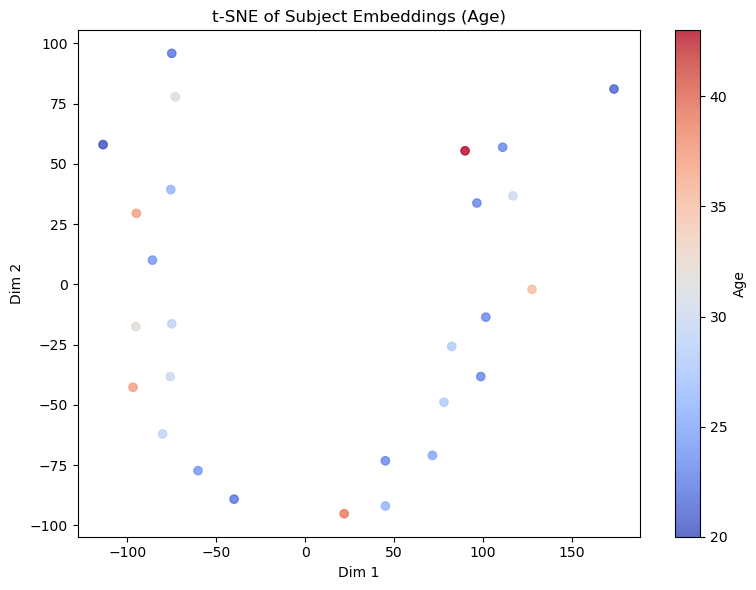

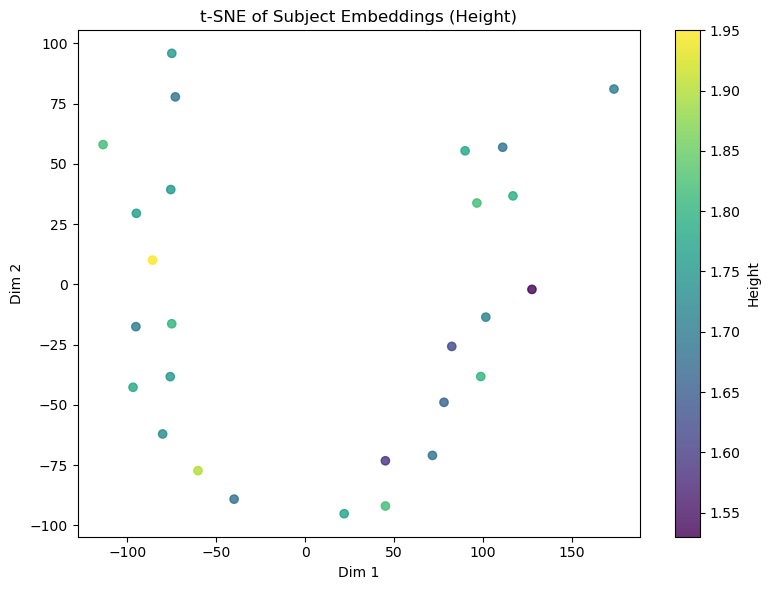

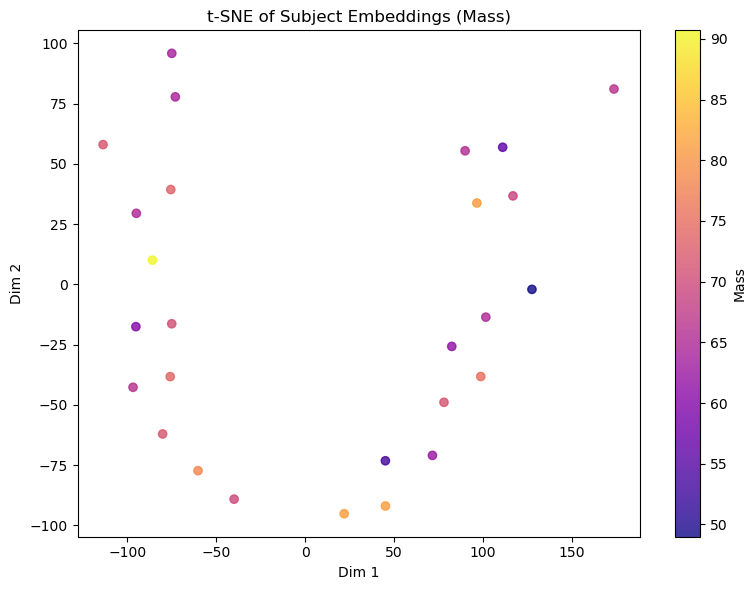

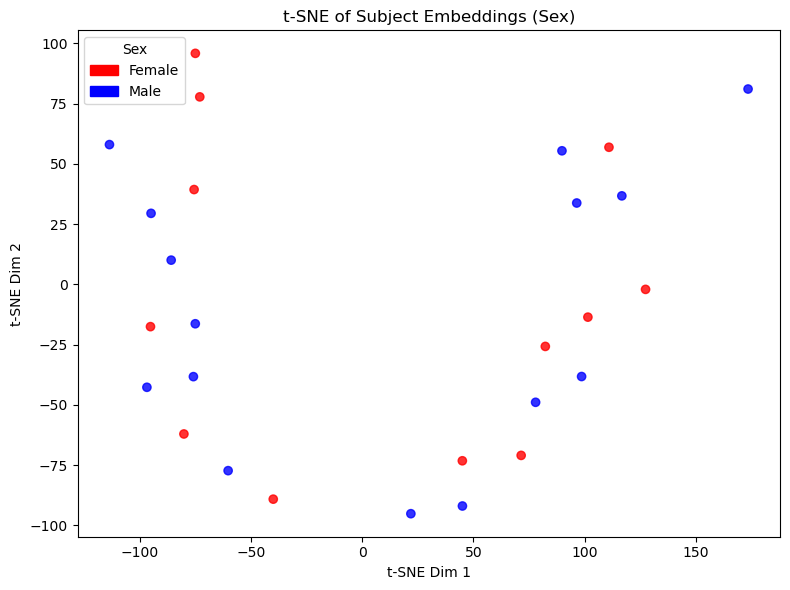

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def plot_heatmap_scatter(embeddings_2d, values, title, cmap='viridis', colorbar_label=None):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=values, cmap=cmap, alpha=0.8)
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    cbar = plt.colorbar(scatter)
    if colorbar_label:
        cbar.set_label(colorbar_label)
    plt.tight_layout()
    plt.show()

def to_numeric(arr):
    arr = np.array(arr)
    mask = arr == 'unknown'
    arr_num = np.where(mask, np.nan, arr).astype(float)
    return arr_num

embeddings = []
ages = []
heights = []
masses = []
sexes = []

subject_list = sorted(subject_latents.keys())
for subject in subject_list:
    latents = subject_latents[subject]
    if len(latents) == 0:
        continue
    latents_tensor = torch.stack(latents).to(device)
    meta_vec, biomech_vec, time_vec = get_features(subject)
    meta_tensor = torch.tensor(meta_vec, device=device).unsqueeze(0).repeat(latents_tensor.shape[0], 1)
    biomech_tensor = torch.tensor(biomech_vec, device=device).unsqueeze(0).repeat(latents_tensor.shape[0], 1)
    time_tensor = torch.tensor(time_vec, device=device).unsqueeze(0).repeat(latents_tensor.shape[0], 1)
    with torch.no_grad():
        profile_vectors = encoder(latents_tensor, meta_tensor, biomech_tensor, time_tensor).detach().cpu().numpy()
        profile = profile_vectors.mean(axis=0)
    meta = dataset.subject_metadata.get(subject, {})
    age = meta.get('age', 'unknown')
    height = meta.get('height', 'unknown')
    mass = meta.get('mass', 'unknown')
    sex = meta.get('sex', 'unknown')
    if age == 'unknown' or age == 0:
        continue
    embeddings.append(profile)
    ages.append(age)
    heights.append(height)
    masses.append(mass)
    sexes.append(sex)

embeddings = np.stack(embeddings)

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
embeddings_2d_tsne = tsne.fit_transform(embeddings)

# For sex, use blue for male and red for female, add a key/legend (no text inside dots)
sexes_arr = np.array(sexes)
sex_to_num = {'female': 0, 'male': 1}
sex_numeric = np.array([sex_to_num.get(s, np.nan) for s in sexes_arr])
cmap_sex = ListedColormap(['red', 'blue'])
legend_handles = [
    mpatches.Patch(color='red', label='Female'),
    mpatches.Patch(color='blue', label='Male')
]

# --- t-SNE plots ---
plot_heatmap_scatter(embeddings_2d_tsne, to_numeric(ages), "t-SNE of Subject Embeddings (Age)", cmap='coolwarm', colorbar_label='Age')
plot_heatmap_scatter(embeddings_2d_tsne, to_numeric(heights), "t-SNE of Subject Embeddings (Height)", cmap='viridis', colorbar_label='Height')
plot_heatmap_scatter(embeddings_2d_tsne, to_numeric(masses), "t-SNE of Subject Embeddings (Mass)", cmap='plasma', colorbar_label='Mass')

plt.figure(figsize=(8, 6))
scatter = plt.scatter(embeddings_2d_tsne[:, 0], embeddings_2d_tsne[:, 1], c=sex_numeric, cmap=cmap_sex, alpha=0.8)
plt.title("t-SNE of Subject Embeddings (Sex)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend(handles=legend_handles, title="Sex", loc='best')
plt.tight_layout()
plt.show()
